## 05: Health Facility Hierarchy and Capability Modelling

**Goal:** To move beyond simple proximity analysis by modelling a more realistic scenario where facilities have different capabilities. In the real world, not all facilities can handle all types of demand (e.g., you wouldn't go to a GP surgery for a major car accident).

This notebook demonstrates how to:
1.  Create a synthetic dataset of health facilities with different types (e.g., GP, Clinic, Hospital).
2.  Assign capabilities or service levels to each facility type.
3.  Model a patient allocation scenario where a patient must be sent to the **nearest appropriate** facility that can handle their required level of care.

### 1. Setup and Library Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from sklearn.neighbors import BallTree
import contextily as cx

### 2. Create Synthetic Datasets

We'll create two datasets:
* A set of health facilities with different types.
* A set of random "incidents" or patients, each requiring a specific level of care.

In [2]:
# Define facility types and their capabilities (care level they can handle)
facility_capabilities = {
    'GP Surgery': 1,
    'Minor Injuries Clinic': 2,
    'Regional Hospital': 3
}

# Create synthetic facilities
np.random.seed(42)
facilities_data = []
for i in range(15):
    facility_type = np.random.choice(list(facility_capabilities.keys()), p=[0.6, 0.3, 0.1])
    facilities_data.append({
        'name': f'{facility_type} {i+1}',
        'type': facility_type,
        'capability': facility_capabilities[facility_type],
        'geometry': Point(np.random.uniform(0, 100), np.random.uniform(0, 100))
    })
facilities_gdf = gpd.GeoDataFrame(facilities_data, crs="EPSG:32630")

# Create synthetic incidents
incidents_data = []
for i in range(5):
    care_level_needed = np.random.randint(1, 4) # Required care level from 1 to 3
    incidents_data.append({
        'incident_id': f'Patient {i+1}',
        'care_level_needed': care_level_needed,
        'geometry': Point(np.random.uniform(20, 80), np.random.uniform(20, 80))
    })
incidents_gdf = gpd.GeoDataFrame(incidents_data, crs="EPSG:32630")

print("Facilities and incidents created.")

Facilities and incidents created.


### 3. Visualize the Initial Setup

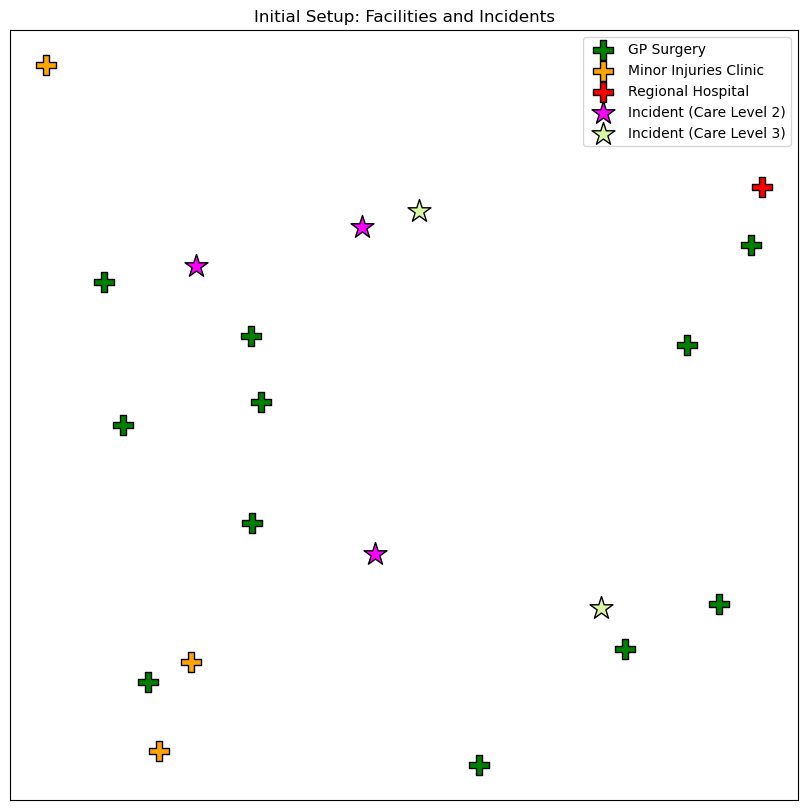

In [3]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot facilities by type
type_colors = {'GP Surgery': 'green', 'Minor Injuries Clinic': 'orange', 'Regional Hospital': 'red'}
for f_type, color in type_colors.items():
    facilities_gdf[facilities_gdf['type'] == f_type].plot(
        ax=ax, color=color, marker='P', markersize=200, label=f_type, edgecolor='black'
    )

# Plot incidents by care level needed
incident_colors = {1: 'cyan', 2: 'magenta', 3: '#DAF7A6'}
for level, color in incident_colors.items():
    subset = incidents_gdf[incidents_gdf['care_level_needed'] == level]
    if not subset.empty:
        subset.plot(
            ax=ax, marker='*', color=color, markersize=300, label=f'Incident (Care Level {level})',
            edgecolor='black'
        )

ax.set_title('Initial Setup: Facilities and Incidents')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper right')
plt.show()

### 4. Allocation Logic: Find Nearest *Appropriate* Facility

For each incident, we will first filter the facilities to include only those that meet or exceed the required care level. Then, from that filtered list, we will find the geographically nearest one.

In [4]:
allocation_lines = []

for idx, incident in incidents_gdf.iterrows():
    # Filter facilities that have the required capability
    capable_facilities = facilities_gdf[facilities_gdf['capability'] >= incident['care_level_needed']]
    
    if capable_facilities.empty:
        print(f"No facility found for {incident['incident_id']} requiring care level {incident['care_level_needed']}")
        continue
    
    # Find the nearest facility among the capable ones
    capable_coords = np.array([pt.coords[0] for pt in capable_facilities.geometry])
    incident_coord = np.array(incident.geometry.coords[0]).reshape(1, -1)
    
    # Use BallTree for efficient nearest neighbor search on projected coordinates
    tree = BallTree(capable_coords)
    dist, ind = tree.query(incident_coord, k=1)
    
    # Get the original index from the filtered dataframe
    nearest_facility_original_idx = capable_facilities.index[ind[0][0]]
    nearest_facility = facilities_gdf.loc[nearest_facility_original_idx]
    
    # Create a line for visualization
    line = LineString([incident.geometry, nearest_facility.geometry])
    allocation_lines.append({
        'incident_id': incident['incident_id'],
        'allocated_to': nearest_facility['name'],
        'geometry': line
    })

allocations_gdf = gpd.GeoDataFrame(allocation_lines, crs="EPSG:32630")

print("Allocation complete.")
print(allocations_gdf[['incident_id', 'allocated_to']])

Allocation complete.
  incident_id             allocated_to
0   Patient 1  Minor Injuries Clinic 5
1   Patient 2  Minor Injuries Clinic 4
2   Patient 3  Minor Injuries Clinic 4
3   Patient 4     Regional Hospital 12
4   Patient 5     Regional Hospital 12


### 5. Visualize the Final Allocation

Let's plot the results, drawing lines from each incident to its assigned facility.

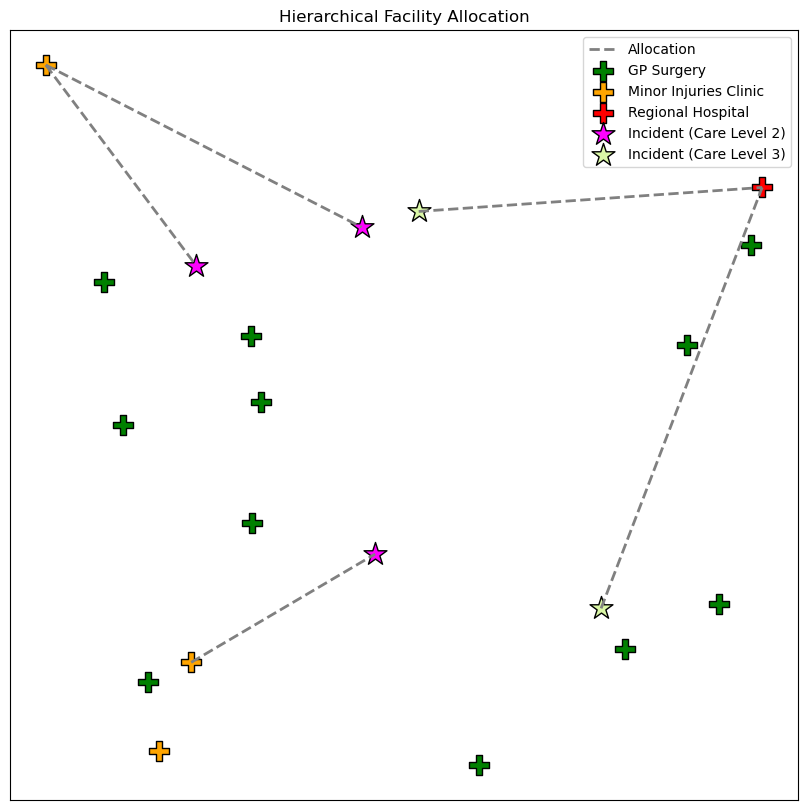

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot allocation lines
allocations_gdf.plot(ax=ax, color='gray', linestyle='--', linewidth=2, label='Allocation')

# Plot facilities by type
for f_type, color in type_colors.items():
    facilities_gdf[facilities_gdf['type'] == f_type].plot(
        ax=ax, color=color, marker='P', markersize=200, label=f_type, edgecolor='black'
    )

# Plot incidents by care level needed
for level, color in incident_colors.items():
    subset = incidents_gdf[incidents_gdf['care_level_needed'] == level]
    if not subset.empty:
        subset.plot(
            ax=ax, marker='*', color=color, markersize=300, label=f'Incident (Care Level {level})',
            edgecolor='black'
        )

ax.set_title('Hierarchical Facility Allocation')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper right')
plt.show()

# Discussion:
# - Notice how incidents are not always assigned to the absolute closest facility. For instance, a high-level incident (e.g., Level 3) might bypass a nearby GP Surgery to go to a farther Regional Hospital.
# - This hierarchical approach is a critical step towards more realistic location-allocation modeling and is essential for planning services like healthcare, emergency response, and tiered retail.